## Analise de Saídas Orçamentárias da Advocacia Geral da União

In [250]:
%%javascript

$('#maintoolbar-container').children('#toggleButton').remove()

var toggle_button = ("<button id='toggleButton' type='button'>Show Code</button>");
$('#maintoolbar-container').append(toggle_button);

var code_shown = false;

function code_toggle()
{

    if (code_shown)
    {
        console.log("code shown")
        $('div.input').hide('500');
        $('#toggleButton').text('Show Code');
    }
    else
    {
        console.log("code not shown")
        $('div.input').show('500');
        $('#toggleButton').text('Hide Code');
    }

    code_shown = !code_shown;
}

$(document).ready(function()
{
    code_shown=false;
    $('div.input').hide();
});

$('#toggleButton').on('click', code_toggle);

<IPython.core.display.Javascript object>

In [251]:
#!pip install convertdate
#!pip install fbprophet
import pandas as pd
import glob
from fbprophet import Prophet


path = r'/home/naubergois/git/bigdata/compras' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, encoding = "ISO-8859-1",sep=";")
    li.append(df)

compras = pd.concat(li, axis=0, ignore_index=True)

## Exemplo de dados usados na análise

In [252]:
compras.head(5)

,CÓDIGO ÓRGÃO SUPERIOR,NOME ÓRGÃO SUPERIOR,CÓDIGO ÓRGÃO,NOME ÓRGÃO,CÓDIGO UNIDADE GESTORA,NOME UNIDADE GESTORA,ANO EXTRATO,MÊS EXTRATO,TIPO AQUISIÇÃO,CNPJ OU CPF FAVORECIDO,NOME FAVORECIDO,TRANSAÇÃO,DATA TRANSAÇÃO,VALOR TRANSAÇÃO
0,63000,ADVOCACIA-GERAL DA UNIAO,63000,ADVOCACIA-GERAL DA UNIAO - UNIDADES COM VÍNCUL...,110581,DIVISAO DE DIARIAS E PASSAGENS DA AGU,2016,11,Aquisição de Passagem Aérea,9296295000160,AZUL LINHAS AEREAS BRASILEIRAS S.A.,COMPRA A/V - R$ - APRES,14/10/2016,"770,50"
1,63000,ADVOCACIA-GERAL DA UNIAO,63000,ADVOCACIA-GERAL DA UNIAO - UNIDADES COM VÍNCUL...,110581,DIVISAO DE DIARIAS E PASSAGENS DA AGU,2016,11,Aquisição de Passagem Aérea,9296295000160,AZUL LINHAS AEREAS BRASILEIRAS S.A.,COMPRA A/V - R$ - APRES,18/10/2016,"602,69"
2,63000,ADVOCACIA-GERAL DA UNIAO,63000,ADVOCACIA-GERAL DA UNIAO - UNIDADES COM VÍNCUL...,110581,DIVISAO DE DIARIAS E PASSAGENS DA AGU,2016,11,Aquisição de Passagem Aérea,9296295000160,AZUL LINHAS AEREAS BRASILEIRAS S.A.,COMPRA A/V - R$ - APRES,20/10/2016,"473,92"
3,63000,ADVOCACIA-GERAL DA UNIAO,63000,ADVOCACIA-GERAL DA UNIAO - UNIDADES COM VÍNCUL...,110581,DIVISAO DE DIARIAS E PASSAGENS DA AGU,2016,11,Aquisição de Passagem Aérea,9296295000160,AZUL LINHAS AEREAS BRASILEIRAS S.A.,COMPRA A/V - R$ - APRES,30/09/2016,"384,54"
4,63000,ADVOCACIA-GERAL DA UNIAO,63000,ADVOCACIA-GERAL DA UNIAO - UNIDADES COM VÍNCUL...,110581,DIVISAO DE DIARIAS E PASSAGENS DA AGU,2016,11,Aquisição de Passagem Aérea,9296295000160,AZUL LINHAS AEREAS BRASILEIRAS S.A.,COMPRA A/V - R$ - APRES,24/10/2016,"434,88"


In [253]:
agu=compras[compras['CÓDIGO ÓRGÃO SUPERIOR']==63000]
agu=agu.filter(['ANO EXTRATO','MÊS EXTRATO','VALOR TRANSAÇÃO'])
agu['VALOR TRANSAÇÃO']=agu['VALOR TRANSAÇÃO'].str.replace(',','.')
agu['VALOR TRANSAÇÃO']=agu['VALOR TRANSAÇÃO'].astype(float)
agu["ds"] = agu["ANO EXTRATO"].astype(str) +'-'+ agu["MÊS EXTRATO"].astype(str)
agu["y"]=agu['VALOR TRANSAÇÃO']

In [254]:
compras_mes_ano=agu.groupby(['ANO EXTRATO','MÊS EXTRATO']).sum()
#compras_mes_ano=agu

In [255]:
compras_mes_ano=compras_mes_ano.reset_index()

In [256]:
compras_mes_ano["ds"] = compras_mes_ano["ANO EXTRATO"].astype(str) +'-'+ compras_mes_ano["MÊS EXTRATO"].astype(str)

In [257]:
compras_mes_ano["y"]=compras_mes_ano['VALOR TRANSAÇÃO']

In [258]:
ultimos_meses=compras_mes_ano[-3:]

## Compras dos últimos meses da base de Dados

In [259]:
ultimos_meses

,ANO EXTRATO,MÊS EXTRATO,VALOR TRANSAÇÃO,y,ds
38,2018,6,160915.06,160915.06,2018-6
39,2018,7,154485.95,154485.95,2018-7
40,2018,8,19626.56,19626.56,2018-8


## Últimos meses usados para treinar o modelo preditivo

In [260]:
compras_mes_ano=compras_mes_ano[:-3]
compras_mes_ano[-3:]

,ANO EXTRATO,MÊS EXTRATO,VALOR TRANSAÇÃO,y,ds
35,2018,2,42539.80,42539.80,2018-2
36,2018,4,208685.75,208685.75,2018-4
37,2018,5,135206.64,135206.64,2018-5


In [261]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(compras_mes_ano)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Tendência e sazonalidade das Compras da AGU

Claramente existe uma tendência de alta das compras governamentais, com redução nos meses de agosto e fevereiro. Dados os últimos dados apresentados para maio de 135.206, projeta-se incremente no valor para os próximos dois meses e redução em agosto.

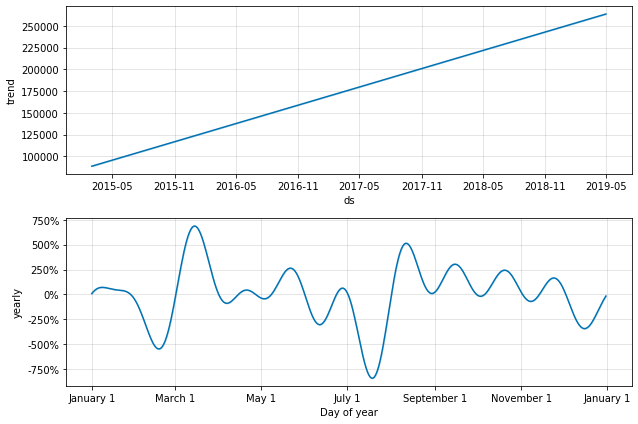

In [262]:
# Python
future = m.make_future_dataframe(periods=12, freq='M')

fcst = m.predict(future)
fig = m.plot_components(fcst)

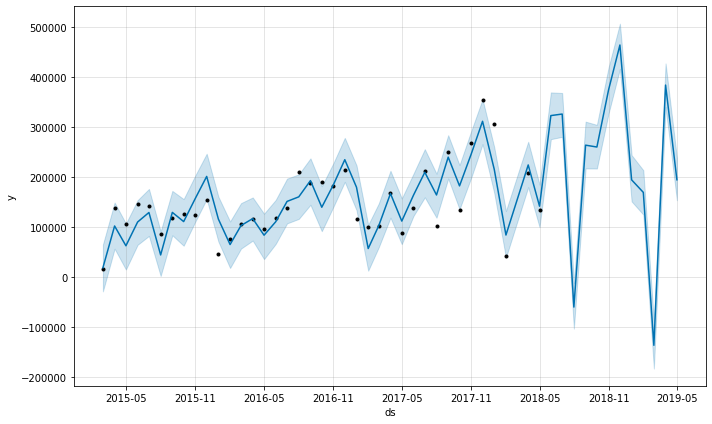

In [263]:
fcst = m.predict(future)
fig = m.plot(fcst)

In [264]:
ultimos_meses

,ANO EXTRATO,MÊS EXTRATO,VALOR TRANSAÇÃO,y,ds
38,2018,6,160915.06,160915.06,2018-6
39,2018,7,154485.95,154485.95,2018-7
40,2018,8,19626.56,19626.56,2018-8


Displaying Prophet plot


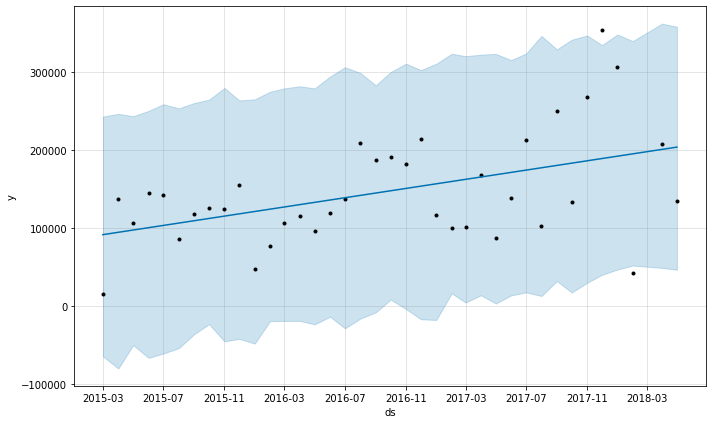

In [265]:
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    print('Displaying Prophet plot')
    fig1 = m.plot(forecast)
    return forecast
    
pred = fit_predict_model(compras_mes_ano)

In [266]:
render(alt.Chart(agu[-5000:]).mark_line(size=15, opacity=0.8, color = 'Orange').encode(
        x='ds',
        y=alt.Y('y', title='Sunspots'),    
        tooltip=['ds', 'y']
    ).interactive().properties(width=900, height=450,title='Sunspots based on Months')\
              .configure_title(fontSize=20))

Displaying Prophet plot


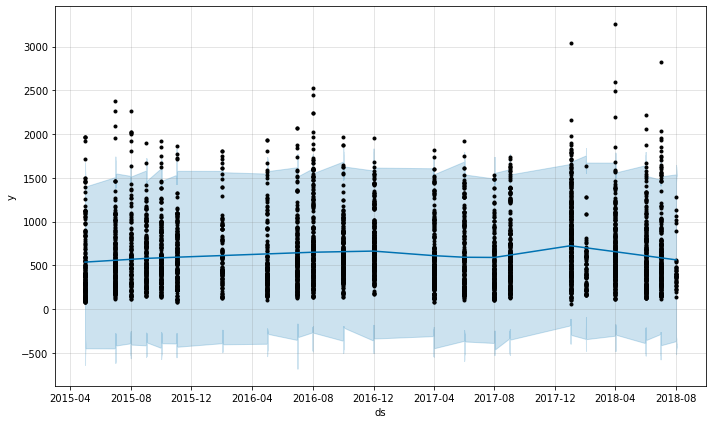

In [267]:
#!pip install altair==2.4.1
#!pip install "vega<2" notebook
#!pip install vega_datasets

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
import altair as alt
alt.renderers.enable('notebook')
from IPython.display import HTML

pred_ = fit_predict_model(agu[-5000:])

def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred_)

In [268]:
pred

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
0,2015-05-01,537.622111,537.622111,-413.799304,1570.393553,630.33,0,0.000000
1,2015-05-01,537.622111,537.622111,-345.837158,1576.099946,579.96,0,0.000000
2,2015-05-01,537.622111,537.622111,-457.366094,1566.882475,640.03,0,0.000000
3,2015-05-01,537.622111,537.622111,-566.300199,1496.932789,261.14,0,0.000000
4,2015-05-01,537.622111,537.622111,-346.965336,1503.138219,653.02,0,0.000000
...,...,...,...,...,...,...,...,...
4995,2018-08-01,563.430722,563.430722,-366.898094,1472.264856,624.12,0,0.000000
4996,2018-08-01,563.430722,563.430722,-378.370905,1503.078435,518.39,0,0.000000
4997,2018-08-01,563.430722,563.430722,-486.417194,1491.415295,1705.68,1,0.125618
4998,2018-08-01,563.430722,563.430722,-338.344950,1488.667900,441.76,0,0.000000


In [269]:
## Dont worry about the code in this block. This is just the setup for showing Altair graphs in Kaggle Notebooks


from  altair.vega import v3
import json
from IPython.display import HTML
alt.renderers.enable('notebook')

vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v3.SCHEMA_VERSION
vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
noext = "?noext"

paths = {
    'vega': vega_url + noext,
    'vega-lib': vega_lib_url + noext,
    'vega-lite': vega_lite_url + noext,
    'vega-embed': vega_embed_url + noext
}

workaround = """
requirejs.config({{
    baseUrl: 'https://cdn.jsdelivr.net/npm/',
    paths: {}
}});
"""

def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
            
@add_autoincrement
def render(chart, id="vega-chart"):
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )

HTML("".join((
    "<script>",
    workaround.format(json.dumps(paths)),
    "</script>",
    "This code block sets up embedded rendering in HTML output and<br/>",
    "provides the function `render(chart, id='vega-chart')` for use below."
)))

## Detecção de Anomalias nas Compras da AGU

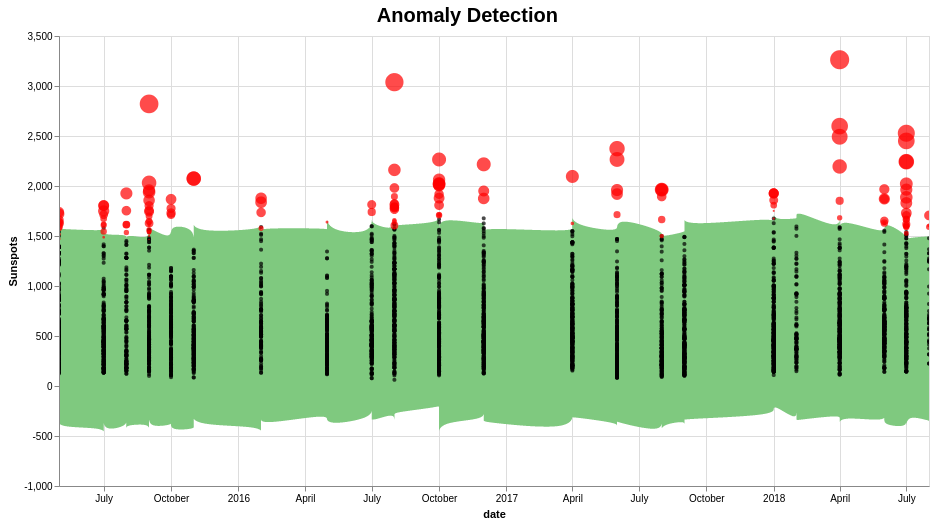

In [270]:
#!pip install vega
#!jupyter nbextension install --sys-prefix --py vega
#!jupyter nbextension enable vega --py --sys-prefix
%matplotlib inline

def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['yearmonthdate(ds)', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='Sunspots'),    
        tooltip=['yearmonthdate(ds)', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='Sunspots'),    
        tooltip=['yearmonthdate(ds)', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)
              
plot_anomalies(pred)